# Echo state network on Lorenz and Sin dataset

### Author: Daniel Mai 

## Project specification

Implement a standard echo state network (ESN) model. Do not include feedback from the output and do not use leaky-integrator neurons. Implement training of the read-out weights by means of ridge regression. Perform experiments and comment the results by considering a _k_ step ahead forecasting task on the "2sine" and "lorentz" time series data provided to you together with this notebook. Evaluate the impact of relevant hyper-parameters on the results, including the reservoir size and the amount of training data used for optimizing the read-out weights. Finally, discuss the effects of using different forecasting horizons on the overall performance of the model. **Note:** it is possible to consider the impact of additional hyperparameters, like the spectral radius of the reservoir matrix, and this will give you some extra points.

### K step ahead forecasting
A _k_ step ahead forecasting task consists of predicting the value of a time series at time $t+k$ by using the value of the time series at time $t$, where $k\geq1$ is called forecasting horizon.
In general, the predicted value is always unidimensional (i.e. a single number). However, it is possible to use multiple input values in order to improve the results. Notably, once _k_ is decided, the output to be predicted is the value of the time series at time $t+k$, and the input may be a vector containing values of the times series at time $t, t-1, \dots, t-n$, where $n\geq0$ is defined by the user and sets the dimensionality of the input vector.

## Your project starts from here!

- Tasks for the remaining project:
    - rework on the split train test data - need to apply the n - how many inputs (input dimension) we want to apply to find the output.
    - Cross-validation - to choose best hyper-parameters for the following hyperparameters: 
        - a (spectral radius) 
        - n_reservoirs - number of reservoir neurons
        - the $\lambda$ - regularization hyper-param
    - Write reports

In [2]:
import matplotlib.pyplot as plt
# make sure plots are correctly displayed in the notebook
%matplotlib inline
import numpy as np

### Reading from files 

In [3]:
def read_file(file_name='lorenz.txt'):
    data = np.genfromtxt(file_name, delimiter='\n', dtype=float)
    return data

### Process the dataset based on the k-step ahead forecasting

- Note: The value of n in the description here I defined to be 1

- Pair data will be split based on k
    - The value of time step t will be paired with the value of time step t+k
    - io_pair $\in R^{(N - k) x 2}$ where N is the number of datas.
    - train_pair $\in R^{(N - k - k) x 2}$ which is used to train the model.
    - test_pair $\in R^{k x 2}$ which is used to test the model.

In [4]:
def train_test_split(data, k=20, n=10):
    '''
        Args:
            data : original data read from files (N,)
            k    : steps for ahead forecasting
        Returns: 
            io_pair ((N-k,2)) : input-output pair of whole data
            train_pair ((N-k-k,2)) : input-output training pair  
            test_pair ((k,2)) : input-output test pair
        
    '''
    io_pair = []
    
    for i in range(len(data) - k - n + 1):
        io_pair.append([])
        input_arr = []
        for j in range(n):
            input_arr.append(data[i+j])
        io_pair[i].append(np.array(input_arr))
        io_pair[i].append(data[i + k + n - 1]) # setting the output

        
    test_size = int(len(data)/3)
    split = len(io_pair) - test_size
    train_pair = io_pair[:split][:]
    test_pair = io_pair[split:][:]
    
    return io_pair, train_pair, test_pair

In [18]:
def train_test_split_1(data, k=20, n=10):
    '''
        Args:
            data : original data read from files (N,)
            k    : steps for ahead forecasting
        Returns: 
            io_pair ((N-k,2)) : input-output pair of whole data
            train_pair ((N-k-k,2)) : input-output training pair  
            test_pair ((k,2)) : input-output test pair
    '''
    io_pair = np.zeros((len(data) - k - n + 1, n + 1), dtype=float)

    for i in range(len(data) - k - n + 1):
        inputs = np.zeros(n)
        for j in range(n):
            inputs[j] = data[i+j]
        io_pair[i, :n] = inputs.squeeze()
        io_pair[i, n: ] = data[i + k + n - 1] # setting the output
        

        
    test_size = int(len(data)/3)
    split = io_pair.shape[0] - test_size
    train_pair = io_pair[:split, :]
    test_pair = io_pair[split:, :]
    
    return io_pair, train_pair, test_pair

In [42]:
data = read_file()
io_pair, train_pair, test_pair = train_test_split_1(data)
train_pair.shape

(10894, 11)

In [39]:
len(train_pair)

10894

In [47]:
train_pair[:, len(train_pair[0])-1:].squeeze()

array([ 2.0885  ,  2.276647,  2.483479, ..., -1.311149, -1.45925 ,
       -1.624448])

In [41]:
train_pair[0:len(train_pair)][10:len(train_pair[0])]

array([[0.42856 , 0.473835, 0.519971, 0.567608, 0.617366, 0.669854,
        0.725681, 0.785466, 0.849844, 0.91948 , 5.063794]])

In [8]:
np.array(train_pair[0][0]).shape

()

In [9]:
io_pair[len(io_pair) - 1]

array([ 8.462578,  9.163709,  9.899992, 10.665068, 11.449814, 12.24194 ,
       13.025714, 13.781908, 14.488091, 15.119361,  3.791413])

In [19]:
np.array(train_pair)

array([[-1.5605800e-01, -7.1057000e-02,  4.5600000e-03, ...,
         3.3786300e-01,  3.8347400e-01,  2.0885000e+00],
       [-7.1057000e-02,  4.5600000e-03,  7.2342000e-02, ...,
         3.8347400e-01,  4.2856000e-01,  2.2766470e+00],
       [ 4.5600000e-03,  7.2342000e-02,  1.3368300e-01, ...,
         4.2856000e-01,  4.7383500e-01,  2.4834790e+00],
       ...,
       [-1.2068133e+01, -1.1364141e+01, -1.0621992e+01, ...,
        -6.2083440e+00, -5.5766020e+00, -6.2379900e-01],
       [-1.1364141e+01, -1.0621992e+01, -9.8588830e+00, ...,
        -5.5766020e+00, -4.9895410e+00, -5.9508800e-01],
       [-1.0621992e+01, -9.8588830e+00, -9.0905830e+00, ...,
        -4.9895410e+00, -4.4487210e+00, -5.7469000e-01]])

In [10]:
len(train_pair)

13079

In [11]:
len(test_pair)

3276

### Initliaze randomized weights

- Elements of **$W^i$** is independently drawn from a uniform distribution in [−1, 1]
- Elements of **$W^r$** directly impacts on the “dynamics” of the network and therefore requires more:
    - uniformly in [-1, 1]
    - $W^r = a\frac{W_r}{p(W^r)}$ where $p(W^r)$ is the spectral radius of $W^r$ and **a** is a scalar hyper-parameter.

In [12]:
def initialize_weights(input_dim, a, n_reservoirs):
    '''
        Args:
            input_dim   : input dimensions
            a           : scalar - hyper-parameter
            n_reservoirs: number of reservoir neurons
        Returns:
            W_in: input-to-recurrent layer weights
            W_r: recurrent layer weights
    '''
    
    W_in = (np.random.rand(n_reservoirs, input_dim) - 0.5) * 1
    W_r = np.random.rand(n_reservoirs, n_reservoirs) - 0.5
    
    # compute the spectral radius of these weights
    spectral_radius = max(abs(np.linalg.eig(W_r)[0]))
    
    # rescale W_r
    W_r = (W_r*a)/spectral_radius
    
    return W_in, W_r

### Metrics for evaluating prediction performance

* Mean-squared error (MSE)

$$
MSE = 〈||t-z||^2〉
$$

    where〈·〉indicates average over time, t and z are target and predicted values, respectively.


* Normalized root MSE (NRMSE)

$$
NRMSE = \frac{\sqrt{MSE}}{var(t)}
$$

In [13]:
def MSE(target, predicted):
    '''
    Args:
        target: target values
        predicted: predicted values
    Returns:
        loss of the model
    '''
    return np.square(np.subtract(target,predicted)).mean()

def NRMSE(target, predicted):
    return MSE(target, predicted)/np.var(t, ddof=1)

### Implement ESN network

#### Standard ESN model:

$x^t = \phi(W^r x_{t-1} + W^i u_t)$         

$z_t = W^o x_t$                             

- where $W^r$ and $W^i$ are randomly initialized, and $W^o$ is obtained as a solution to a (regularized) least-square problem

    - $W^r \in R^{N_r x N_r}$, where $N_r$ is the number of neurons in the recurrent layer (reservoir)
    - $W^i \in R^{N_r x N_i}$ is the input-to-reservoir weight matrix, $N_i$ is the input dimension
    - $W^o \in R^{N_o x N_r}$ is the read-output weight matrix, $N_o$ is the output dimension 
    - Activation function $\phi(x)$, I will use in this project is the **tanh** activation function 
    
    - **NOTE**: In this project, **N_o** and **N_i** is equal to 1 since we are dealing with ***unidimensional*** dataset



- The state $x_t$ can be seen as a vector of **temporal features**

- The sequence of states $x_t, t = 1,..., N$ is the **representation learned** by the ESN of the driving input $u_t$, $t = 1,...,N$

#### Ridge regression for the read-out weights

- Regularized least-square problem for $W_o$: 

    arg min $\frac{1}{2}||XW - t||^2 + \frac{\lambda}{2}||W||^2$ where $\lambda >= 0$ is the *regularization parameter*
    
    
- The closed form solution for the above problem is:

    $W^o = (X^TX + \lambda I)^{-1}X^Tt$ where **I** is an $N_r x N_r$ identity matrix
    
    - $W^o$ should be **transposed** before further use in the model
    
    
- Assume a supervised task (such as forecasting) and dataset $\{u_i, t_i\}^N_{i=1}$

Steps for **batch training**:
1. Initialize all model parameters $W^i$, $W^r$
2. Initialize the first state as $x_0 = 0$
3. Feed the network with the sequence of inputs $u_i$, i = 1, ...,N
4. Collect the resulting N states $x_i$ in a matrix $X \in R^{N x N_r}$
5. Store all related targets in a N-dimensional vector $t \in R^N$
6. Find $W^o$ by solving a regularized least-square problem

In [87]:
def ESN_train(train_pair, n_reservoirs=200, a=0.95, lamda=0.01):
    '''
        Args:
            train_pair ((N,2)) : training input-output pair  where N is number of training pairs
            n_reservoirs       : number of reservoir neurons
            a                  : scalar - hyper-parameter used for initialize recurrent weights 
            lamda              : hyper-parameter used in ridge regression for read-out weights
        Returns:
            W_in
            W_r
            W_out ((, N_r))       : read-output weight matrix
    '''
    n_pairs = train_pair.shape[0]
    n_dims = train_pair.shape[1] - 1 #input dimensions
    # initialize all model weights/parameters
    # Note: I hardcoded the input dimension (= 1) here
    #       since the input data set is unidimensional.
    W_i, W_r = initialize_weights(n_dims, a, n_reservoirs) 
    
    # initialize the first state
    x = np.zeros((n_reservoirs,))
    
    # initialize holder for collecting N states x_i in a matrix X 
    X = np.zeros((n_pairs, n_reservoirs))
    
    # Feed the network with sequence of inputs u_i
    # and collect the resulting N states x_i in a matrix X.
    for i in range(n_pairs):
        u = np.array(train_pair[i, :n_dims]) # inputs
        x = np.tanh(np.dot(W_r, x) + np.dot(W_i, u))
        X[i, :] = x.squeeze()
    
    # Store all targeted values for those training inputs in a N-dimensional vector
    t = np.array(train_pair[:, n_dims:]).squeeze()
    t = np.expand_dims(t, axis=0)
    
    # calculating W_o
    X = X.T
    W_o = np.linalg.solve(np.dot(X, X.T) + np.multiply(lamda,np.identity(n_reservoirs)), np.dot(X, t.T)).T
    return x, W_i, W_r, W_o

In [92]:
def ESN_k_step_predict(test_pair, x, W_in, W_r, W_out, k=20):
    '''
        Args:
            training_pair    : training input-output pair ((N,2)) where N is number of training pairs
            x                : current state after finish training
            W_in
            W_r
            W_out ((1, N_r)) : optimized read-output weight matrix
            k                : steps for ahead forecasting (hyperparameter)
        Returns:
            loss             : 
            targeted_values  : 
            predicted_values : 
    '''
    
    # intialize holder for predicted time series
    #predicted_values = np.zeros((1,k)) 
    n_dims = test_pair.shape[1] - 1
    test_size = test_pair.shape[0]
    predicted_values = np.zeros((1,test_size)) 
    # get the input time value
    u = test_pair[0,:n_dims]
    
    for t in range(test_pair.shape[0]):
        x = np.tanh(np.dot(W_in,u) + np.dot(W_r,x))
        z = np.dot(W_out, x)
        predicted_values[:,t] = z
        u = z

    targeted_values = np.expand_dims(test_pair[:,1], axis=0)

    loss = MSE(targeted_values, predicted_values)
    
    return loss, targeted_values, predicted_values
    

In [93]:
data = read_file()
io_pair, train_pair, test_pair = train_test_split_1(data)
x, W_i, W_r, W_o = ESN_train(train_pair)
print(W_r.shape)

loss, targeted_values, predicted_values = ESN_k_step_predict(test_pair, x, W_i, W_r, W_o)

(200, 200)


ValueError: shapes (200,10) and (1,) not aligned: 10 (dim 1) != 1 (dim 0)

In [96]:
test_pair

array([[-0.093054, -0.102296, -0.11255 , ..., -0.202577, -0.223891,
        -1.808711],
       [-0.102296, -0.11255 , -0.123928, ..., -0.223891, -0.247577,
        -2.01422 ],
       [-0.11255 , -0.123928, -0.136553, ..., -0.247577, -0.273908,
        -2.243385],
       ...,
       [ 7.180121,  7.800651,  8.462578, ..., 13.025714, 13.781908,
         5.387925],
       [ 7.800651,  8.462578,  9.163709, ..., 13.781908, 14.488091,
         4.557258],
       [ 8.462578,  9.163709,  9.899992, ..., 14.488091, 15.119361,
         3.791413]])

In [98]:
np.array(test_pair[0, :10])

array([-0.093054, -0.102296, -0.11255 , -0.123928, -0.136553, -0.150565,
       -0.16612 , -0.183393, -0.202577, -0.223891])

### Plot Functions

In [12]:
def plot_result_function(data, predicts, k=20, a=0.95, reservoir=200):
    plt.figure(figsize=(11, 1.5)).clear()
    plt.plot(range(0, len(data)), data.T, 'k', label="target system")
    plt.plot(range(len(data)-len(predicts.T.squeeze()), len(data)), predicts.T, 'r', label='predicted system' )
    plt.title(' prediction for k = ' + str(k) + " num_reservoirs = " +str(reservoir) + " a = " + str(a))

### Experiments on Lorenz datatset

In [55]:
lorenz_data = read_file('lorenz.txt')

for num reservoirs = 200 and k = 1 --> loss: 105.94853057183082
for num reservoirs = 200 and k = 1 --> loss: 112.26117556442038
for num reservoirs = 200 and k = 1 --> loss: 113.50052191143966
for num reservoirs = 200 and k = 1 --> loss: 70.1007247264345
for num reservoirs = 200 and k = 1 --> loss: 102.4872366481134
for num reservoirs = 200 and k = 10 --> loss: 23628.732347418856
for num reservoirs = 200 and k = 10 --> loss: 2826.3106263072705
for num reservoirs = 200 and k = 10 --> loss: 2086.723808646766
for num reservoirs = 200 and k = 10 --> loss: 3115.7205163115677
for num reservoirs = 200 and k = 10 --> loss: 2681.013162912364
for num reservoirs = 200 and k = 15 --> loss: 6829.8866863849535
for num reservoirs = 200 and k = 15 --> loss: 12975.812924468673
for num reservoirs = 200 and k = 15 --> loss: 4475.530523948835
for num reservoirs = 200 and k = 15 --> loss: 3465.3173343402036
for num reservoirs = 200 and k = 15 --> loss: 7152.384005658959
for num reservoirs = 200 and k = 20 -

C:\Users\Maith\AppData\Local\Temp/ipykernel_4004/3375365232.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(11, 1.5)).clear()


for num reservoirs = 200 and k = 25 --> loss: 23718.56020596681
for num reservoirs = 200 and k = 25 --> loss: 14460.439612222373
for num reservoirs = 200 and k = 25 --> loss: 5706.6474618225075
for num reservoirs = 200 and k = 25 --> loss: 9989.75904883955
for num reservoirs = 300 and k = 1 --> loss: 118.39223620568924
for num reservoirs = 300 and k = 1 --> loss: 117.32906831332876
for num reservoirs = 300 and k = 1 --> loss: 134.28540172822926
for num reservoirs = 300 and k = 1 --> loss: 124.05528894695249
for num reservoirs = 300 and k = 1 --> loss: 122.55053329767077
for num reservoirs = 300 and k = 10 --> loss: 23041.653386692215
for num reservoirs = 300 and k = 10 --> loss: 9961.917400846834
for num reservoirs = 300 and k = 10 --> loss: 7653.778029941731
for num reservoirs = 300 and k = 10 --> loss: 53581.486104524476
for num reservoirs = 300 and k = 10 --> loss: 5230.215197730494
for num reservoirs = 300 and k = 15 --> loss: 9526.63544736651
for num reservoirs = 300 and k = 15 --

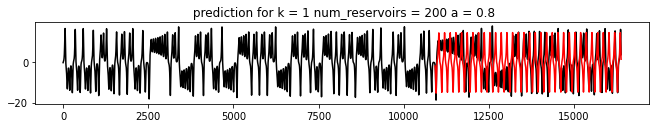

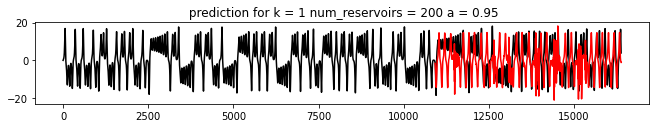

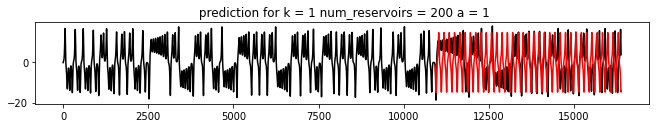

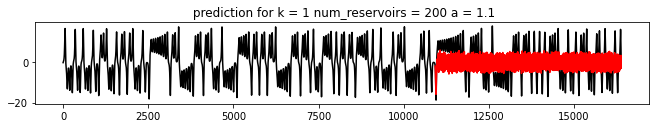

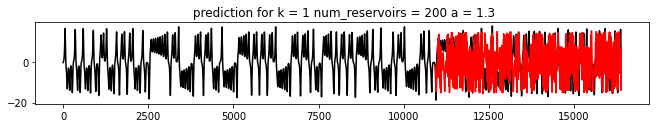

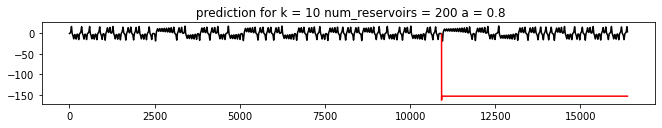

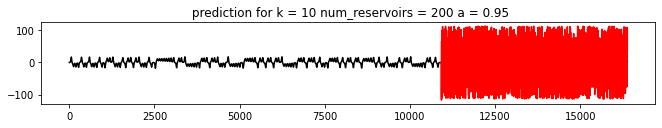

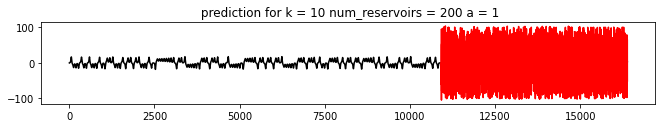

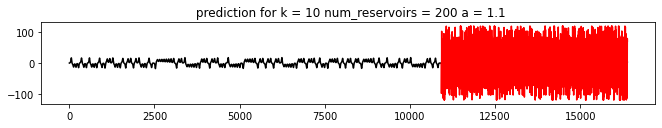

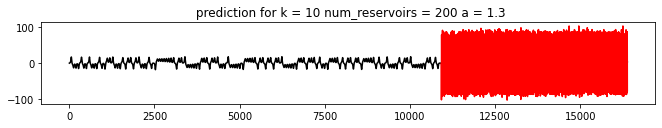

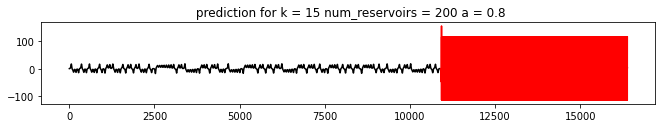

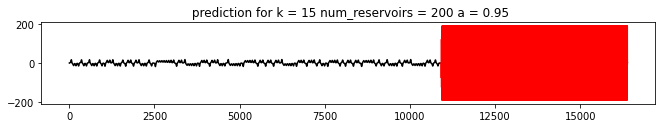

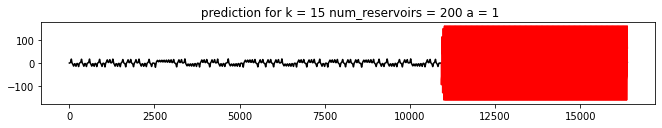

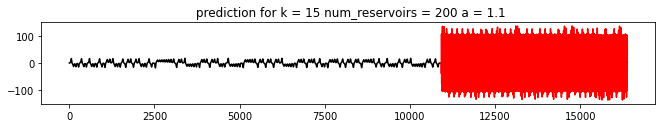

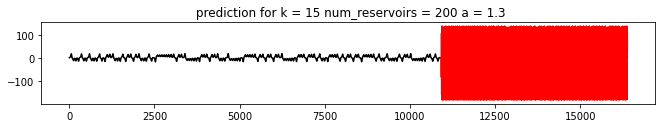

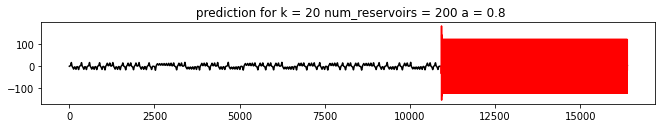

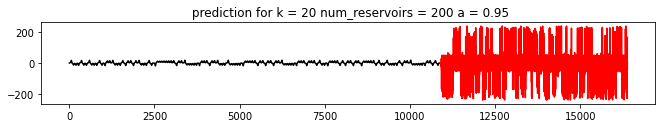

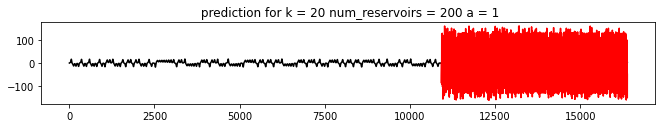

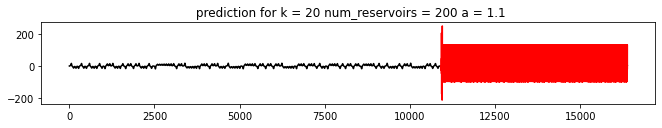

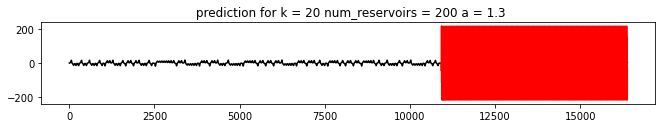

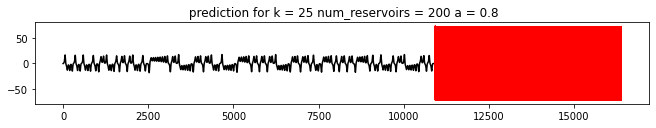

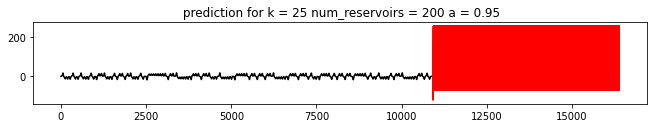

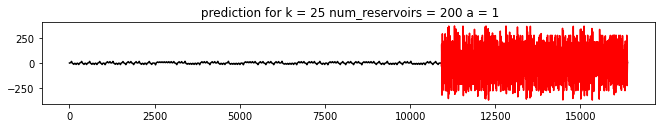

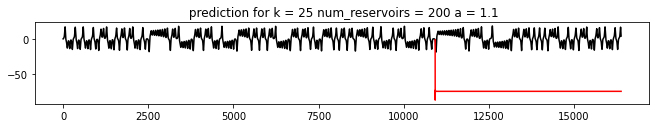

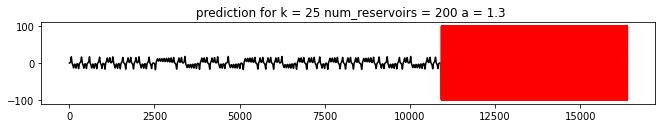

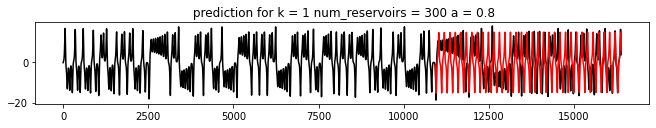

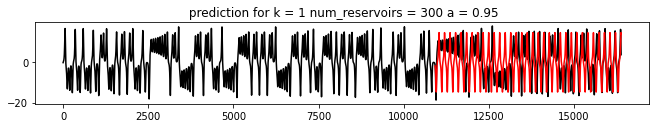

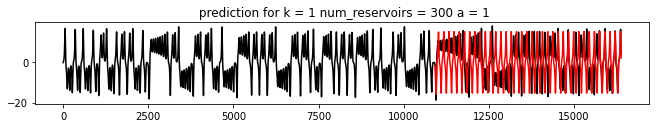

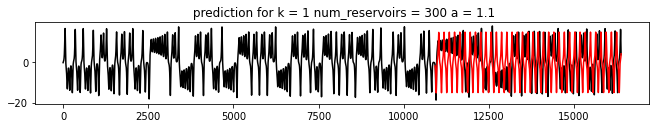

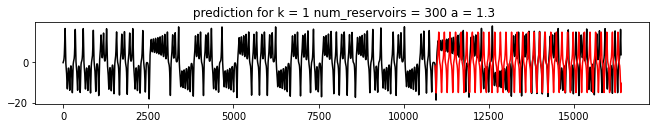

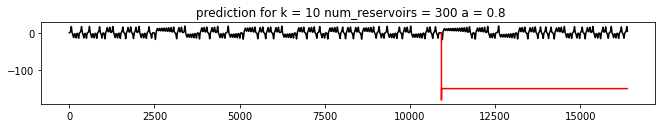

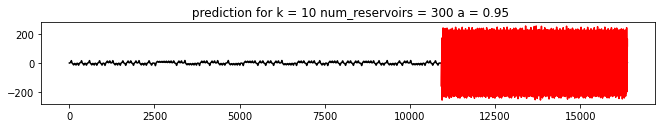

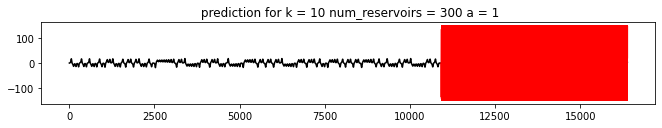

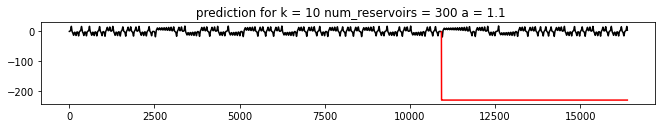

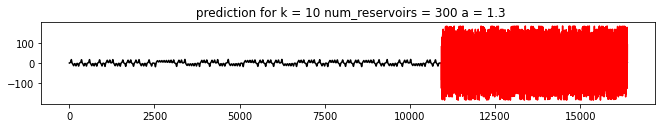

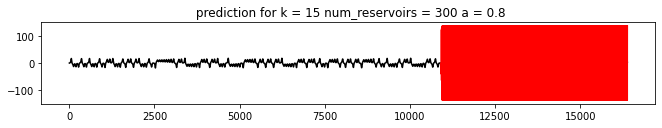

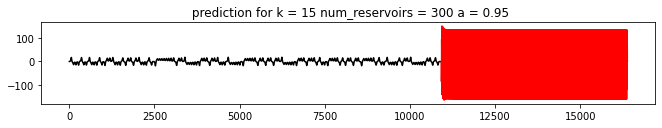

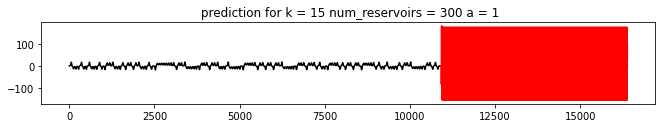

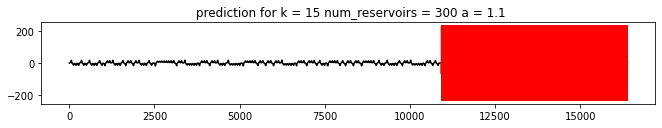

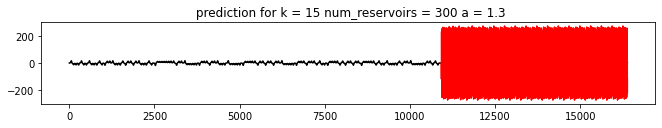

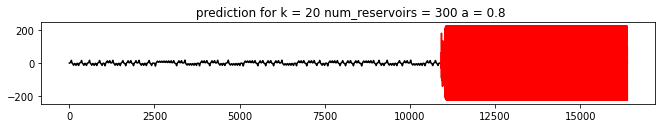

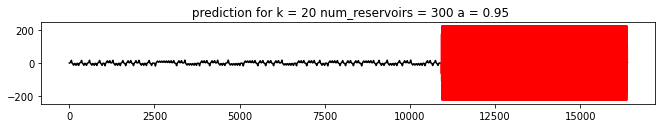

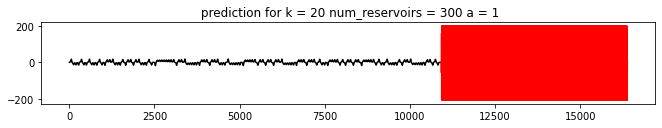

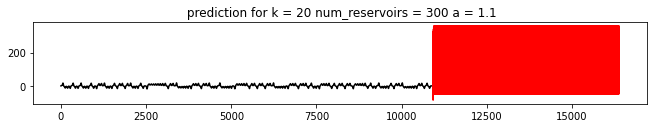

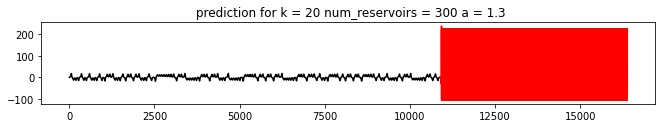

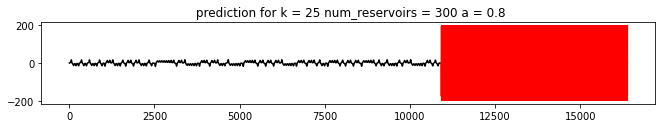

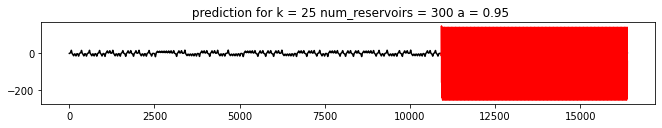

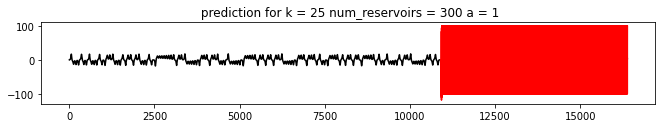

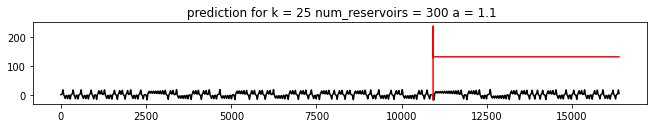

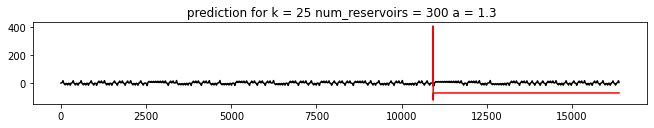

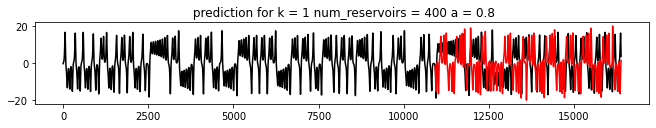

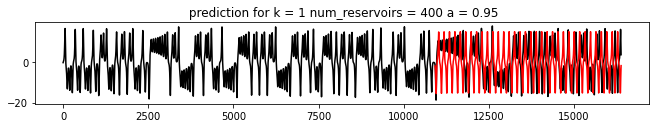

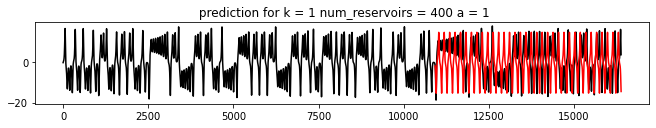

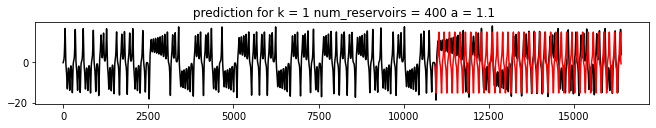

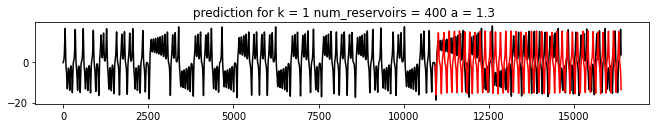

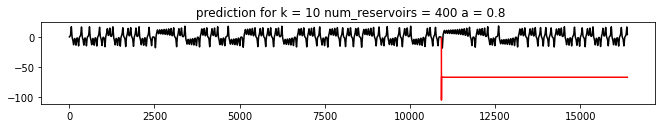

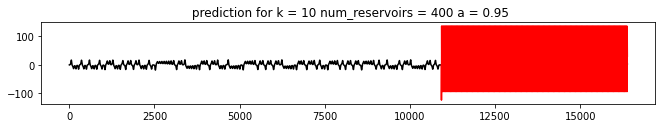

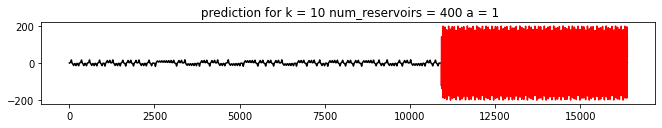

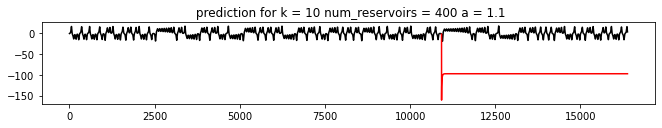

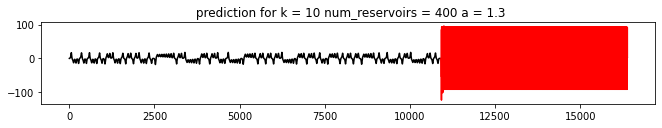

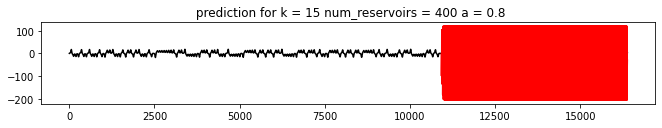

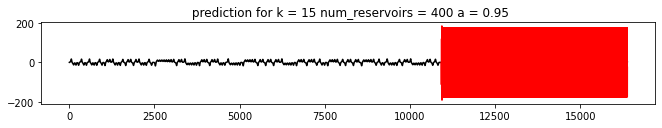

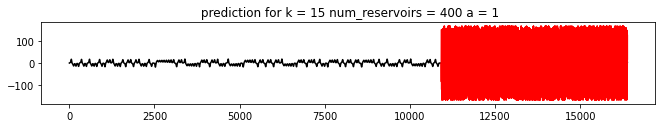

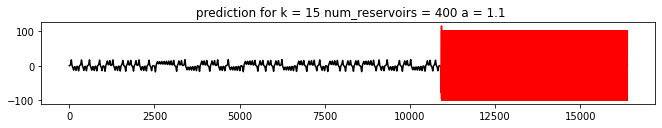

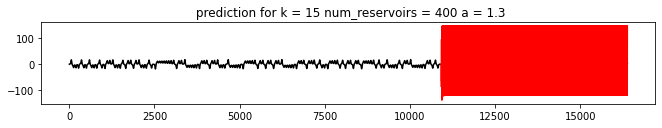

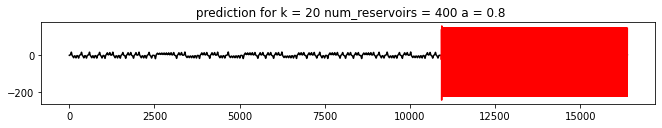

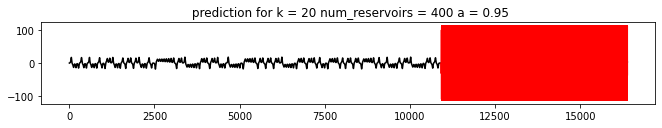

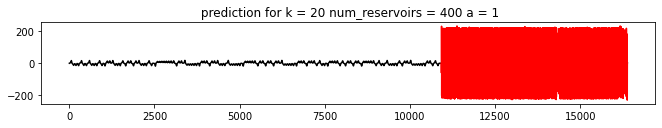

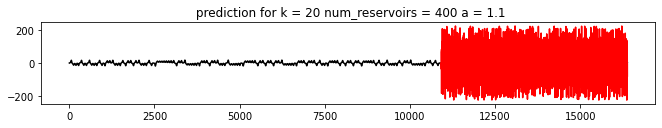

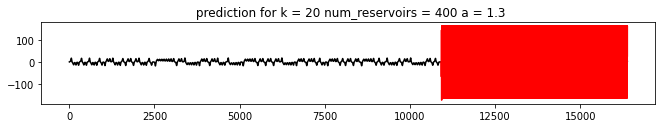

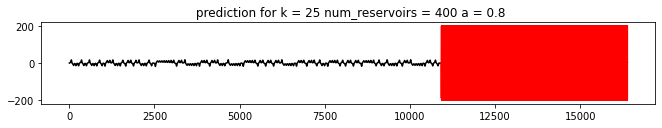

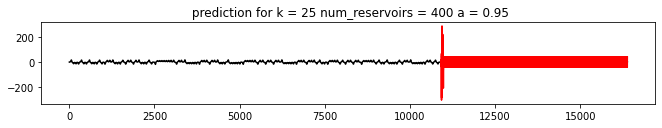

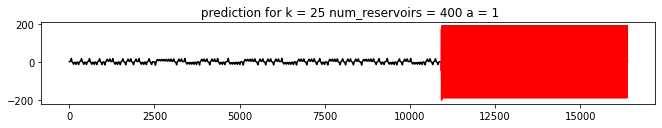

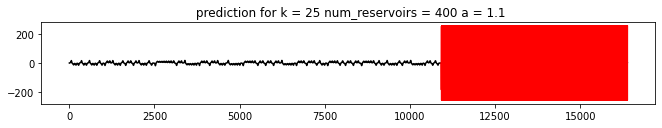

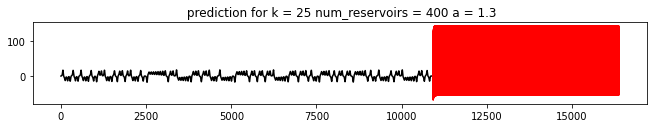

In [130]:
n_reservoirs = [200, 300, 400]
a_tests = [0.8,0.95, 1, 1.1, 1.3]
k_tests = [1, 10, 15, 20, 25]


for num_reservoir in n_reservoirs:
    for k in k_tests:
        for a in a_tests:
            io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split(lorenz_data, k=k)
            lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=num_reservoir)
            lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                                          lorenz_current_state,
                                                                          lorenz_W_in,
                                                                          lorenz_W_r,
                                                                          lorenz_W_out,
                                                                          k=k)
            print('for num reservoirs = ' + str(num_reservoir) + ' and k = ' + str(k) + ' --> loss: '+ str(lorenz_test_loss))
            plot_result_function(lorenz_data, lorenz_predicts, k, a, num_reservoir)

In [60]:
io_pair, lorenz_train_pair, lorenz_test_pair = train_test_split_1(lorenz_data, k=25)

In [61]:
lorenz_current_state, lorenz_W_in, lorenz_W_r, lorenz_W_out = ESN_train(lorenz_train_pair, n_reservoirs=400)

[ 3.235423  3.537075  3.868173 ... -1.311149 -1.45925  -1.624448]


In [64]:
lorenz_test_loss, lorenz_targets, lorenz_predicts = ESN_k_step_predict(lorenz_test_pair,
                                                                      lorenz_current_state,
                                                                      lorenz_W_in,
                                                                      lorenz_W_r,
                                                                      lorenz_W_out,
                                                                      k=25)

ValueError: shapes (400,10) and (1,) not aligned: 10 (dim 1) != 1 (dim 0)

In [134]:
print(lorenz_test_loss)

33852.61439112866


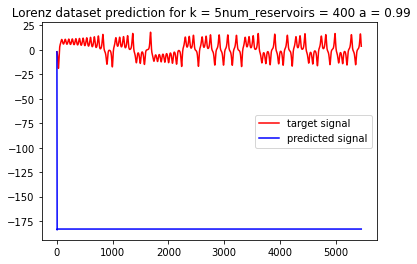

In [135]:
k = 5
a = 0.99
reservoir = 400
plt.figure(11).clear()
plt.plot( lorenz_targets.T, 'r' )
plt.plot( lorenz_predicts.T, 'b' )
plt.title(' Lorenz dataset prediction for k = ' + str(k) + "num_reservoirs = " +str(reservoir) + " a = " + str(a))
plt.legend(['target signal', 'predicted signal'])

### Experiments on 2sin dataset

In [126]:
sin_data = read_file('2sin.txt')

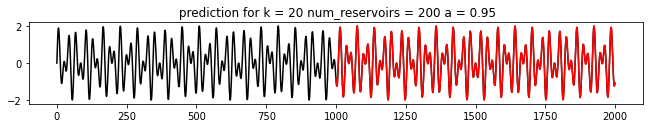

In [127]:
io_pair, sin_train_pair, sin_test_pair = train_test_split(sin_data,k=1)
plot_result_function(sin_data, sin_targets)

In [13]:
n_reservoirs = [200, 300, 400]
a_tests = [0.8,0.95, 1, 1.1, 1.3]
k_tests = [1, 10, 15, 20, 25]

io_pair, sin_train_pair, sin_test_pair = train_test_split(sin_data,k=1)
for num_reservoir in n_reservoirs:
    for a in a_tests:
        
        sin_current_state, sin_W_in, sin_W_r, sin_W_out = ESN_train(sin_train_pair, n_reservoirs=num_reservoir, a=a)
        sin_test_loss, sin_targets, sin_predicts = ESN_k_step_predict(sin_test_pair,
                                                          sin_current_state,
                                                          sin_W_in,
                                                          sin_W_r,
                                                          sin_W_out,
                                                          k=1)
        print('for num reservoirs = ' + str(num_reservoir) + ' and k = ' + str(k) + ' --> loss: '+ str(sin_test_loss))

        plot_result_function(sin_data, sin_predicts, k=1, a, num_reservoir)

SyntaxError: positional argument follows keyword argument (Temp/ipykernel_1968/951878464.py, line 18)

NOTE:
- number of reservoir = 300 and a = 1.1 gives the best results for now
- a <= 1 gives inappropriate result for this case for some reasons(?)
- a=1.1 tends to predict well on all num experimented reservoirs